In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import random
import keras
from keras.models import Sequential
import time
from keras.optimizers import Adam,RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
import pandas as pd
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
covid_path= '/content/drive/MyDrive/Coughvid /MFCC1/COVID-19'
healthy_path = '/content/drive/MyDrive/Coughvid /MFCC1/healthy'
symptomatic_path = '/content/drive/MyDrive/Coughvid /MFCC1/symptomatic'

In [ ]:
covid_model = covid_path + '/0b0d7e10-8353-4124-a16b-bf96e405f63c.png'
healthy_model = healthy_path + '/0aa0ef30-0df7-42d0-b1bf-017f8647b92c.png'
symptomatic_model = symptomatic_path + '/0bbac203-c99f-4895-ad6a-85202f1d93a2.png'

In [ ]:
df = pd.DataFrame()

In [ ]:
X1 = []
X2 = []
Y = []

for file in os.listdir(covid_path):
  X1.append(covid_model)
  X2.append(os.path.join(covid_path,file))
  Y.append(0)

for file in os.listdir(healthy_path):
  X1.append(healthy_model)
  X2.append(os.path.join(healthy_path,file))
  Y.append(0)

for file in os.listdir(symptomatic_path):
  X1.append(symptomatic_model)
  X2.append(os.path.join(symptomatic_path,file))
  Y.append(0)

In [ ]:
for file in os.listdir(covid_path):
  X1.append(healthy_model)
  X1.append(symptomatic_model)
  X2.append(os.path.join(covid_path,file))
  X2.append(os.path.join(covid_path,file))
  Y.append(1)
  Y.append(1)

for file in os.listdir(healthy_path):
  X1.append(covid_model)
  X1.append(symptomatic_model)
  X2.append(os.path.join(healthy_path,file))
  X2.append(os.path.join(healthy_path,file))
  Y.append(1)
  Y.append(1)

for file in os.listdir(symptomatic_path):
  X1.append(healthy_model)
  X1.append(covid_model)
  X2.append(os.path.join(symptomatic_path,file))
  X2.append(os.path.join(symptomatic_path,file))
  Y.append(1)
  Y.append(1)

In [ ]:
df["X1"] = X1
df["X2"] = X2
df["Y"] = Y

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2)

In [4]:
input_imgen = ImageDataGenerator(rescale = 1./255)

test_imgen = ImageDataGenerator(rescale = 1./255)



def generate_generator_multiple(generator,df, batch_size, img_height,img_width):
    genX1 = generator.flow_from_dataframe(df,
                                          directory = None,
                                          x_col = "X1",
                                          y_col = "Y",
                                          color_mode = "grayscale",
                                          target_size = (img_height,img_width),
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_dataframe(df,
                                          directory = None,
                                          x_col = "X2",
                                          y_col = "Y",
                                          color_mode = "grayscale",
                                          target_size = (img_height,img_width),
                                          class_mode = 'raw',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            
batch_size = 128
img_height = 300
img_width = 300

inputgenerator=generate_generator_multiple(generator=input_imgen,
                                           df = train,
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_height)       
     
             
          

NameError: ignored

In [3]:
def create_model(input_shape):
  left_input = Input(input_shape)
  right_input = Input(input_shape)
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])
  prediction = Dense(1,activation='sigmoid')(L1_distance)

 

  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siamese_net

In [5]:
model = create_model((300, 300, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 300, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          43675008    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           sequential[0][0]             

In [6]:
optimizer = Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')

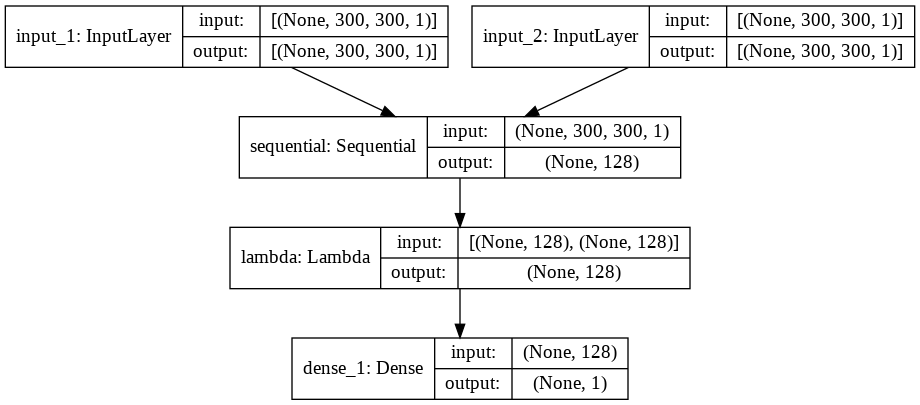

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
 history=model.fit(inputgenerator,
                        steps_per_epoch=len(train)/batch_size,
                        epochs = 6,
                        use_multiprocessing=True,
                        shuffle=False)

Found 6115 validated image filenames.
Found 6115 validated image filenames.
Epoch 1/6
47/47 [==============================] - 260s 5s/step - loss: 0.6825 - accuracy: 0.6001
Epoch 2/6
47/47 [==============================] - 242s 5s/step - loss: 0.5939 - accuracy: 0.6868
Epoch 3/6
47/47 [==============================] - 244s 5s/step - loss: 0.5642 - accuracy: 0.7037
Epoch 4/6
47/47 [==============================] - 244s 5s/step - loss: 0.5390 - accuracy: 0.7313
Epoch 5/6
47/47 [==============================] - 244s 5s/step - loss: 0.5179 - accuracy: 0.7434
Epoch 6/6
47/47 [==============================] - 243s 5s/step - loss: 0.4935 - accuracy: 0.7660


In [ ]:
model.save('/content/drive/MyDrive/Coughvid ')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Coughvid /assets


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Coughvid ')

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

We have a test folder with 100 images from each class

In [ ]:
test_folder = '/content/drive/MyDrive/Coughvid /MFCC1/test'

In [ ]:
test_df = pd.DataFrame()

In [ ]:
anchor = []
testing = []
label = []
for folder in os.listdir(test_folder):
  foldern = os.path.join(test_folder,folder)
  for file in os.listdir(foldern):
    filename = os.path.join(foldern,file)
    if folder=="COVID-19":
      anchor.append(covid_model)
      testing.append(filename)
      label.append(0)
      anchor.append(healthy_model)
      anchor.append(symptomatic_model)
      testing.append(filename)
      testing.append(filename)
      label.append(1)
      label.append(1)
    if folder=="symptomatic":
      anchor.append(symptomatic_model)
      testing.append(filename)
      label.append(0)
      anchor.append(healthy_model)
      anchor.append(covid_model)
      testing.append(filename)
      testing.append(filename)
      label.append(1)
      label.append(1)
    if folder=="healthy":
      anchor.append(healthy_model)
      testing.append(filename)
      label.append(0)
      anchor.append(covid_model)
      anchor.append(symptomatic_model)
      testing.append(filename)
      testing.append(filename)
      label.append(1)
      label.append(1)

In [ ]:
len(label)

900

In [ ]:
test_df["X1"] = anchor
test_df["X2"] = testing
test_df["Y"] = label

In [ ]:
testgenerator=generate_generator_multiple(test_imgen,
                                          df = test_df,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height) 

In [ ]:
pred = model.predict(testgenerator, steps = len(test_df)/batch_size)

In [ ]:
test_df["preds"] = pred

In [ ]:
data = test_df[["Y","preds"]].head(30)

In [ ]:
prediction = [1]*900

In [ ]:
for i in range(0,len(pred)-3,3):
  value0 = pred[i]
  value1 = pred[i+1]
  value2 = pred[i+2]
  li = (value0,value1,value2)
  index = li.index(min(li))
  pos = i + index
  prediction[pos] = 0

In [ ]:
test_df["prediction"] = prediction

In [ ]:
true = test_df["Y"]

In [ ]:
test_df

X1  ... prediction
0    /content/drive/MyDrive/Coughvid /MFCC1/COVID-1...  ...          0
1    /content/drive/MyDrive/Coughvid /MFCC1/healthy...  ...          1
2    /content/drive/MyDrive/Coughvid /MFCC1/symptom...  ...          1
3    /content/drive/MyDrive/Coughvid /MFCC1/COVID-1...  ...          1
4    /content/drive/MyDrive/Coughvid /MFCC1/healthy...  ...          1
..                                                 ...  ...        ...
895  /content/drive/MyDrive/Coughvid /MFCC1/healthy...  ...          1
896  /content/drive/MyDrive/Coughvid /MFCC1/COVID-1...  ...          1
897  /content/drive/MyDrive/Coughvid /MFCC1/symptom...  ...          1
898  /content/drive/MyDrive/Coughvid /MFCC1/healthy...  ...          1
899  /content/drive/MyDrive/Coughvid /MFCC1/COVID-1...  ...          1

[900 rows x 5 columns]

In [ ]:
print("Accuracy is {}".format(accuracy_score(test_df["Y"].to_list(),test_df["prediction"].to_list())))

Accuracy is 0.6566666666666666


In [ ]:
def print_recall(check):
  correct = 0
  total = 0
  for _,x in test_df.iterrows():
    category = x["X2"].split("/")[7]
    truth = x["Y"]
    pre = x["prediction"]
    if category==check:
      total+=1
      if truth==pre:
        correct+=1
  accuracy = correct/total
  print("Recall of {} is {} ".format(check,accuracy))

In [ ]:
print_recall("COVID-19")

Recall of COVID-19 is 0.8133333333333334 


In [ ]:
print_recall("healthy")

Recall of healthy is 0.5933333333333334 


In [ ]:
print_recall("symptomatic")

Recall of symptomatic is 0.5633333333333334 
